In [1]:
import warnings
warnings.filterwarnings("ignore")
import pymc4 as pm4
import pymc3 as pm3
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import numpy as np
import arviz as az

```
Original Stan model
data {
  int<lower=0> J; // number of schools
  real y[J]; // estimated treatment effects
  real<lower=0> sigma[J]; // s.e. of effect estimates
}
parameters {
  real mu;
  real<lower=0> tau;
  real eta[J];
}
transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] <- mu + tau * eta[j];
}
model {
  eta ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
```

In [2]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12], dtype=np.float32)
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18], dtype=np.float32)

In [36]:
@pm4.model
def schools_pm4():
    #eta = yield pm4.Normal("eta", 0, 1, plate=J)
    
    # Unfortunately these have to be scalar tensors, maybe default to plate=1?
    eta = yield pm4.Normal("eta", tf.zeros(J), tf.ones(J))
    mu = yield pm4.Normal("mu", tf.zeros(1), tf.ones(1))
    tau = yield pm4.HalfNormal('tau', tf.ones(1) * 2.)

    theta = mu + tau * eta

    obs = yield pm4.Normal('obs', theta, sigma=sigma, observed=y)

In [37]:
@pm4.model
def schools_pm4():
    eta = yield pm4.Normal("eta", 0, 1, plate=J)
    mu = yield pm4.Normal("mu", 0, 1, plate=1)
    tau = yield pm4.HalfNormal('tau', 2., plate=1)
    
    theta = mu + tau * eta

    obs = yield pm4.Normal('obs', theta, sigma=sigma, observed=y)

In [38]:
%%time
tf_trace = pm4.inference.sampling.sample(schools_pm4(), 
                                         step_size=.28,
                                         num_chains=5, 
                                         num_samples=100,
                                         xla=False)

CPU times: user 13 s, sys: 433 ms, total: 13.4 s
Wall time: 12.7 s


In [51]:
%%time
tf_trace = pm4.inference.sampling.sample(schools_pm4(), 
                                         step_size=.28,
                                         num_chains=50, 
                                         num_samples=100,
                                         xla=False)

CPU times: user 22.4 s, sys: 1.26 s, total: 23.7 s
Wall time: 18.3 s


TODO: Make work with XLA

In [52]:
%%time
tf_trace = pm4.inference.sampling.sample(schools_pm4(), 
                                         step_size=.28,
                                         num_chains=50, 
                                         num_samples=100,
                                         xla=True)

AttributeError: in converted code:
    relative to /Users/twiecki:

    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/compiler/xla/xla.py:106 xla_compile_wrapper  *
        return _compile_internal(computation, inputs)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/compiler/xla/xla.py:352 _compile_internal
        outputs = computation(*computation_inputs)
    working/projects/pymc4/pymc4/inference/tensorflow/sampling.py:111 run_chains  *
        results = mcmc.sample_chain(
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:362 sample_chain
        parallel_iterations=parallel_iterations)
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/internal/util.py:371 trace_scan
        parallel_iterations=parallel_iterations)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2478 while_loop_v2
        return_same_structure=True)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2675 while_loop
        back_prop=back_prop)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/while_v2.py:196 while_loop
        add_control_dependencies=add_control_dependencies)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py:911 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/while_v2.py:174 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/internal/util.py:360 _body
        state = loop_fn(state, elems_array.read(i))
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:346 _trace_scan_fn
        parallel_iterations=parallel_iterations)
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/internal/util.py:287 smart_for_loop
        parallel_iterations=parallel_iterations
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2478 while_loop_v2
        return_same_structure=True)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2675 while_loop
        back_prop=back_prop)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/while_v2.py:196 while_loop
        add_control_dependencies=add_control_dependencies)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py:911 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/while_v2.py:174 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/internal/util.py:285 <lambda>
        body=lambda i, *args: [i + 1] + list(body_fn(*args)),
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/dual_averaging_step_size_adaptation.py:459 one_step
        current_state, inner_results)
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/nuts.py:361 one_step
        parallel_iterations=TF_WHILE_PARALLEL_ITERATIONS,
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2478 while_loop_v2
        return_same_structure=True)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2675 while_loop
        back_prop=back_prop)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/while_v2.py:196 while_loop
        add_control_dependencies=add_control_dependencies)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py:911 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/while_v2.py:174 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/nuts.py:356 <lambda>
        metastate),
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/nuts.py:530 loop_tree_doubling
        momentum_state_memory)
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/nuts.py:711 _build_sub_tree
        parallel_iterations=TF_WHILE_PARALLEL_ITERATIONS,
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2478 while_loop_v2
        return_same_structure=True)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2675 while_loop
        back_prop=back_prop)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/while_v2.py:196 while_loop
        add_control_dependencies=add_control_dependencies)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py:911 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/while_v2.py:174 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/nuts.py:699 <lambda>
        not_divergence, momentum_state_memory)),
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/nuts.py:748 _loop_build_sub_tree
        prev_tree_state.target_grad_parts)
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/internal/leapfrog_integrator.py:289 __call__
        target_grad_parts,
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2478 while_loop_v2
        return_same_structure=True)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/control_flow_ops.py:2675 while_loop
        back_prop=back_prop)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/while_v2.py:196 while_loop
        add_control_dependencies=add_control_dependencies)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py:911 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/while_v2.py:174 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/internal/leapfrog_integrator.py:283 <lambda>
        body=lambda i, *args: [i + 1] + list(self._one_step(*args)),  # pylint: disable=no-value-for-parameter
    anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/internal/leapfrog_integrator.py:332 _one_step
        ng.set_shape(g.shape)

    AttributeError: 'IndexedSlices' object has no attribute 'set_shape'


In [19]:
import arviz as az

In [41]:
tf_trace[1].numpy().shape

(200, 50, 8)

In [45]:
tf_trace[0].numpy().shape

(200, 50, 1)

In [53]:
# TODO: Order changes for different runs, should fix order
trace_tfp = az.from_dict({'eta': np.swapaxes(tf_trace[1].numpy(), 1, 0),
                          'mu':  tf_trace[0].numpy()[..., 0].T,
                          'tau': tf_trace[2].numpy()[..., 0].T})

In [54]:
trace_tfp.posterior.eta

<xarray.DataArray 'eta' (chain: 50, draw: 200, eta_dim_0: 8)>
array([[[-0.424085,  0.386967, ..., -1.612401, -1.236677],
        [-0.091168, -0.407339, ...,  0.341199, -1.110973],
        ...,
        [-0.336987,  0.227154, ...,  1.68521 ,  0.470025],
        [ 0.701393,  1.263167, ...,  0.696871,  0.517866]],

       [[ 0.479623, -0.200544, ..., -0.221755,  1.290452],
        [ 0.297577,  1.363272, ...,  2.009586,  0.117197],
        ...,
        [ 1.324438, -0.153447, ..., -0.027444, -0.52494 ],
        [ 0.638103,  1.323655, ..., -0.333055,  1.219152]],

       ...,

       [[-0.375676, -0.428169, ...,  0.180596, -0.991369],
        [ 0.514708, -0.476738, ..., -0.082625,  1.037093],
        ...,
        [ 0.446482, -0.185806, ..., -0.308831, -0.01781 ],
        [ 1.028021,  0.481877, ..., -0.583185, -0.020315]],

       [[-0.209811,  0.062431, ..., -0.834763, -0.622843],
        [ 0.087055, -0.180356, ...,  0.317345,  0.614182],
        ...,
        [ 1.319062,  0.986808, ...,  1.26

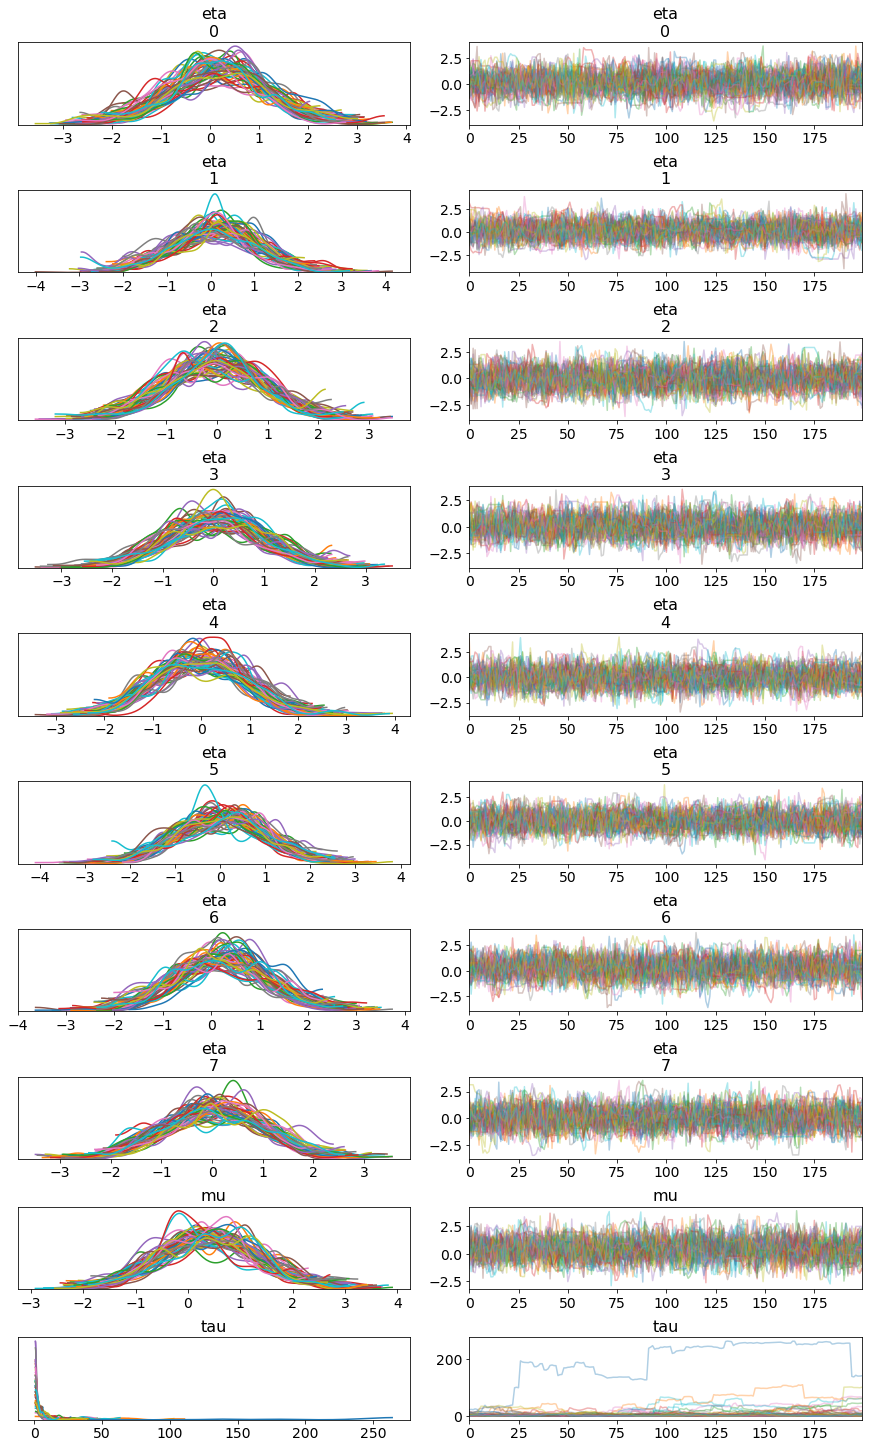

In [55]:
az.plot_trace(trace_tfp);

## Using python NUTS sampler

In [56]:
from pymc4 import hmc

In [57]:
model = schools_pm4()
logp_func, tensors = pm4.inference.sampling.build_logp_function(model)

In [67]:
def logp_array(input_tensors):
    t1, t2, t3 = input_tensors[:8], input_tensors[8], input_tensors[9]
    tensors = [t1, t2, t3]
    with tf.GradientTape() as tape:
        tape.watch(tensors)
        logp = logp_func(*[tensors])
    grad = tape.gradient(logp, tensors)

    return logp, grad

# As the above function expects TF inputs and outputs, wrap it as PyMC3's samplers want numpy
def logp_wrapper(arr):
    #logp, grad = logp_array([tf.convert_to_tensor(arr) for arr in arrs])
    logp, grad = logp_array(tf.convert_to_tensor(arr))
    grad = np.concatenate([np.atleast_1d(l.numpy()) for l in grad])
    return logp, grad#,.numpy(), grad.numpy()

In [68]:
size = 10
n_samples = 500

sampler = hmc.NUTS(logp_dlogp_func=logp_wrapper, 
                   size=size, 
                   dtype=np.float32)

curr = np.ones(size, dtype='float32') * .05
posterior_samples = []
stats = []

In [69]:
%%time
for i in range(n_samples):
    curr, stat = sampler.step(curr)
    posterior_samples.append(curr)
    stats.append(stat)
    if i % 20 == 0:
        print(i)
    
trace = np.array(posterior_samples)

ValueError: Invalid reduction dimension -1 for input with 0 dimensions. for 'exp_2_1/forward_log_det_jacobian/Sum' (op: 'Sum') with input shapes: [], [1] and with computed input tensors: input[1] = <-1>.

In [ ]:
trace_python = az.from_dict({'eta': trace[:, :8].T[..., np.newaxis].T, 
                             'mu':  trace[:, 8, np.newaxis].T, 
                             'tau': trace[:, 9, np.newaxis].T})

In [ ]:
az.plot_trace(trace_python);